
<h1 align=center><font size = 5>Capstone Project - The Battle of the Neighborhoods (Week 2)</font></h1>

## Table of contents
* [Introduction: Business Problem](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Analysis](#Analysis)
* [Results and Discussion](#Results)
* [Conclusion](#Conclusion)

## Introduction

My objective is, through the data provided by foursquare and the Bogota City Hall, to segment Bogota's neighborhoods through an unsupervised algorithm such as KMeans, to determine the best place to establish a bar and restaurant supply store 

### A high level approach is as follows:

The ForeSquare website allows you to obtain information about the main venues in the city, including bars and restaurants with their respective categories, for example fast food restaurante, peruvian restaurant, etc.  This list also contains geographic information of each location, which will allow you to segment the neighborhoods according to the type of venues in it and visualize their location throughout the city to determine the best place to establish a store for these bars and restaurants. 


### There are many data science aspect of this project including:

Data Acquisition from Bogota Citi Hall and Foursquare <br/>
Data Cleansing <br/>
Data Analysis <br/>
Machine Learning - unsupervised cloustering <br/>
Prediction <br/>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wget zsh -f


Usage:   
  /Users/duarfel/opt/anaconda3/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /Users/duarfel/opt/anaconda3/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /Users/duarfel/opt/anaconda3/bin/python -m pip install [options] [-e] <vcs project url> ...
  /Users/duarfel/opt/anaconda3/bin/python -m pip install [options] [-e] <local project path> ...
  /Users/duarfel/opt/anaconda3/bin/python -m pip install [options] <archive url/path> ...

-f option requires 1 argument
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes  #uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Data

Based on definition of our problem, factors that will influence our decission are:

* number of existing restaurants in the neighborhood (any type of restaurant)
* Distance of neighborhood choosed to the mainly restaurants zone

Following data sources will be needed to extract/generate the required information:
* Data of neighborhoods with major number of restaurants in Bogotá was taked form City Hall Data website : https://datosabiertos.bogota.gov.co
* The number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [5]:
!wget -q -O 'bogota_data.json' https://datosabiertos.bogota.gov.co/dataset/b0c66a77-3230-4d0c-a119-dead7f9b8b8e/resource/9c3829e3-6b4b-4aac-a3e5-297fe0127b67/download/egba.geojson
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [6]:
with open('bogota_data.json') as json_data:
    bogota_data = json.load(json_data)
#bogota_data

Let's take a quick look at the data.

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [7]:
neighborhoods_data = bogota_data['features']

Let's take a look at the first item in this list.

In [8]:
neighborhoods_data[0]

{'type': 'Feature',
 'properties': {'SUBCATEGOR': 'L',
  'NOMBRE_EST': 'CHIBCHOMBIA',
  'DIRECCION': 'CL 27 # 4 - 49 P 1',
  'LOC': '03',
  'SECTOR_CAT': 'LA MACARENA',
  'LATITUD': 4.613799,
  'LONGITUD': -74.066259},
 'geometry': {'type': 'Point',
  'coordinates': [-74.06625899961625, 4.613799000073394]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [9]:
# define the dataframe columns
column_names = ['Borough','Name','Address','Subcategory', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [38]:
neighborhoods.

,Borough,Name,Address,Subcategory,Neighborhood,Latitude,Longitude
0,03,CHIBCHOMBIA,CL 27 # 4 - 49 P 1,L,LA MACARENA,4.613799,-74.066259
1,03,RESTAURANTE ROMULO Y REMO MACARENA,KR 4A # 26D - 90,L,LA MACARENA,4.613799,-74.066259
2,03,BOGOTA BEER COMPANY S A,KR 4A # 27 - 3,L,LA MACARENA,4.614092,-74.065890
3,03,PRESTO BTA CALLE 27,KR 7 # 27 - 38 LC 1 ED COLISSEUM,L,SAN DIEGO,4.614158,-74.069222
4,03,LA HAMBURGUESERIA DE LA MACARENA,KR 4A # 27 - 27,L,LA MACARENA,4.614193,-74.066440


Then let's loop through the data and fill the dataframe one row at a time.

In [11]:
for data in neighborhoods_data:
    name = data['properties']['NOMBRE_EST'] 
    LOC = data['properties']['LOC'] 
    address = data['properties']['DIRECCION']
    subcategoy = data['properties']['SUBCATEGOR']
    neighborhood= data['properties']['SECTOR_CAT']
    lat= data['properties']['LATITUD']
    long= data['properties']['LONGITUD']
    
    neighborhoods = neighborhoods.append({'Borough': LOC,
                                          'Name': name,
                                          'Address': address,
                                          'Subcategory':subcategoy,
                                          'Neighborhood': neighborhood,
                                          'Latitude': lat,
                                          'Longitude': long}, ignore_index=True)

Quickly examine the resulting dataframe.

In [12]:
neighborhoods.head(100)

,Borough,Name,Address,Subcategory,Neighborhood,Latitude,Longitude
0,03,CHIBCHOMBIA,CL 27 # 4 - 49 P 1,L,LA MACARENA,4.613799,-74.066259
1,03,RESTAURANTE ROMULO Y REMO MACARENA,KR 4A # 26D - 90,L,LA MACARENA,4.613799,-74.066259
2,03,BOGOTA BEER COMPANY S A,KR 4A # 27 - 3,L,LA MACARENA,4.614092,-74.065890
3,03,PRESTO BTA CALLE 27,KR 7 # 27 - 38 LC 1 ED COLISSEUM,L,SAN DIEGO,4.614158,-74.069222
4,03,LA HAMBURGUESERIA DE LA MACARENA,KR 4A # 27 - 27,L,LA MACARENA,4.614193,-74.066440
5,03,MC DONALD S CENTRO INTERNACIONAL,KR 10 # 26 - 55,L,SAN DIEGO,4.614194,-74.070309
6,03,BOCA COCINA LATINA,KR 10 # 27 - 51 LC 174 ED Residencias Tequenda...,L,SAN DIEGO,4.614208,-74.070278
7,03,GAUDI RESTAURANTE ESPAÑOL,KR 4A # 27 - 52,K,LA MACARENA,4.614401,-74.066068
8,03,REPUBLIK MUSEO,TV 6 # 27 - 50 LC 2,L,SAN DIEGO,4.614652,-74.068623
9,03,ARCHIES CENTRO INTERNACIONAL,KR 7 # 27 - 80,J,SAN DIEGO,4.614853,-74.069126


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 15 boroughs and 515 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Bogotá D.C..

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>explorer</em>, as shown below.

In [14]:
address = 'Bogota, Colombia'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bogotá D.C. are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bogotá D.C. are 4.59808, -74.0760439.


In [83]:
df_topn=neighborhoods.groupby('Neighborhood').count().sort_values(['Name'],ascending=False)
df_topn=df_topn[['Name']]

In [84]:
df_topneiborhoods=df_topn.rename(columns={"Name": "Count"}).nlargest(5,['Count'])
df_topneiborhoods.head()

,Count
Neighborhood,
USAQUEN,41
EL RETIRO,40
CHICO NORTE,28
CIUDAD SALITRE NOR-ORIENTAL,22
MIRANDELA,20


#### Create a map of Bogota with neighborhoods superimposed on top.

In [93]:
# create map of Bogota using latitude and longitude values
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  
    
map_bogota

As we did with all of Bogotá D.C., let's visualizat bogota the neighborhoods in it.

#### Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'U5HBM0544TWPO4G52TXO5POYFSGGZKHZV0LD1R4CLRND01GN' # your Foursquare ID
CLIENT_SECRET = 'JXOBNNXG3Y3GVUTNR20Q3RY5JGDHEC1LRS3AO1NXRVPZJKIP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: U5HBM0544TWPO4G52TXO5POYFSGGZKHZV0LD1R4CLRND01GN
CLIENT_SECRET:JXOBNNXG3Y3GVUTNR20Q3RY5JGDHEC1LRS3AO1NXRVPZJKIP


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [18]:
neighborhood_fs=neighborhoods.groupby('Neighborhood').mean().reset_index()

neighborhood_fs

,Neighborhood,Latitude,Longitude
0,AEROPUERTO EL DORADO,4.690904,-74.134005
1,ANTIGUO COUNTRY,4.671517,-74.057248
2,BELLAVISTA,4.655442,-74.054903
3,BOCHICA II,4.710940,-74.112074
4,CEDRITOS,4.717639,-74.033637
5,CEMENTERIO JARDINES APOGEO,4.597093,-74.176075
6,CENTRO ADMINISTRATIVO,4.596079,-74.075121
7,CHAPINERO CENTRAL,4.640445,-74.065861
8,CHAPINERO NORTE,4.652679,-74.061606
9,CHICO NORTE,4.676578,-74.048629


Get the neighborhood's latitude and longitude values.

In [19]:

neighborhood_latitude = neighborhood_fs.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhood_fs.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name= neighborhood_fs.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of AEROPUERTO EL DORADO are 4.690904263157895, -74.1340046842105.


First, let's create the GET request URL. Name your URL **url**.

In [20]:
# type your answer here

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,  
    neighborhood_latitude, 
    neighborhood_longitude,
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=U5HBM0544TWPO4G52TXO5POYFSGGZKHZV0LD1R4CLRND01GN&client_secret=JXOBNNXG3Y3GVUTNR20Q3RY5JGDHEC1LRS3AO1NXRVPZJKIP&v=20180605&ll=4.690904263157895,-74.1340046842105&radius=500&limit=100'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f20ebd46102276221910281'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Aeropuerto El Dorado',
  'headerFullLocation': 'Aeropuerto El Dorado, Bogotá',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 21,
  'suggestedBounds': {'ne': {'lat': 4.695404267657899,
    'lng': -74.12949798601662},
   'sw': {'lat': 4.686404258657891, 'lng': -74.13851138240437}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55ef708d498ef7f599495935',
       'name': 'BBC La Bodega - Terminal Puente Aéreo',
       'location': {'lat': 4.693784745511199,
        'lng': -74.13515286278391,
        'labeledLatLngs': [{'label': 'display',
          'lat': 

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-23-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,BBC La Bodega - Terminal Puente Aéreo,Brewery,4.693785,-74.135153
1,Juan Valdez Café,Café,4.693891,-74.135197
2,Top Sushi Wok,Sushi Restaurant,4.691265,-74.136686
3,Juan Valdez Café,Café,4.693489,-74.134734
4,Movich Buro 26,Hotel,4.689655,-74.130106


And how many venues were returned by Foursquare?

In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

21 venues were returned by Foursquare.


<a id='item2'></a>

## Methodology

#### Let's create a function to repeat the same process to all the neighborhoods in bogota

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *bogota_venues*.

In [26]:
# type your answer here

bogota_venues = getNearbyVenues(names=neighborhood_fs['Neighborhood'],
                                   latitudes=neighborhood_fs['Latitude'],
                                   longitudes=neighborhood_fs['Longitude']
                                  )



AEROPUERTO EL DORADO
ANTIGUO COUNTRY
BELLAVISTA
BOCHICA II
CEDRITOS
CEMENTERIO JARDINES APOGEO
CENTRO ADMINISTRATIVO
CHAPINERO CENTRAL
CHAPINERO NORTE
CHICO NORTE
CHICO NORTE II SECTOR
CHICO NORTE III SECTOR
CIUDAD HAYUELOS
CIUDAD SALITRE NOR-ORIENTAL
EGIPTO
EL CHICO
EL NOGAL
EL RETIRO
EMAUS
ESPARTILLAL
GALERIAS
GRANADA
HIPOTECHO
HIPOTECHO OCCIDENTAL
JULIO FLOREZ
LA CABRERA
LA CALLEJA
LA CAROLINA
LA CASTELLANA
LA CATEDRAL
LA ESPERANZA NORTE
LA MACARENA
LA SOLEDAD
LAGO GAITAN
LAS AGUAS
LAS CRUCES
LAS MARGARITAS
LAS NIEVES
LAS VILLAS
LISBOA
LOS ALAMOS
LOS ANDES
METROPOLIS
MIRANDELA
NIZA SUR
ORTEZAL
PALOQUEMAO
PORCIUNCULA
PROVIVIENDA ORIENTAL
QUINTA CAMACHO
SALAZAR GOMEZ
SALITRE OCCIDENTAL
SAMPER
SAN ANTONIO NOROCCIDENTAL
SAN DIEGO
SAN JOSE DEL PRADO
SAN MARTIN
SAN PATRICIO
SANTA ANA OCCIDENTAL
SANTA BARBARA CENTRAL
SANTA BARBARA OCCIDENTAL
SANTA BARBARA ORIENTAL
SANTA BIBIANA
SANTA HELENA
SANTA MONICA
SANTA ROSA
SUCRE
TORCA I
TUNAL ORIENTAL
USAQUEN
VERACRUZ
VILLA ALSACIA
VILLA ELISA
VILL

Double-click __here__ for the solution.
<!-- The correct answer is:
bogota_venues = getNearbyVenues(names=bogota_data['Neighborhood'],
                                   latitudes=bogota_data['Latitude'],
                                   longitudes=bogota_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [27]:
print(bogota_venues.shape)
bogota_venues.head()

(3559, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AEROPUERTO EL DORADO,4.690904,-74.134005,BBC La Bodega - Terminal Puente Aéreo,4.693785,-74.135153,Brewery
1,AEROPUERTO EL DORADO,4.690904,-74.134005,Juan Valdez Café,4.693891,-74.135197,Café
2,AEROPUERTO EL DORADO,4.690904,-74.134005,Top Sushi Wok,4.691265,-74.136686,Sushi Restaurant
3,AEROPUERTO EL DORADO,4.690904,-74.134005,Juan Valdez Café,4.693489,-74.134734,Café
4,AEROPUERTO EL DORADO,4.690904,-74.134005,Movich Buro 26,4.689655,-74.130106,Hotel


Let's check how many venues were returned for each neighborhood

In [28]:
bogota_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AEROPUERTO EL DORADO,21,21,21,21,21,21
ANTIGUO COUNTRY,36,36,36,36,36,36
BELLAVISTA,99,99,99,99,99,99
BOCHICA II,26,26,26,26,26,26
CEDRITOS,27,27,27,27,27,27
CEMENTERIO JARDINES APOGEO,4,4,4,4,4,4
CENTRO ADMINISTRATIVO,84,84,84,84,84,84
CHAPINERO CENTRAL,71,71,71,71,71,71
CHAPINERO NORTE,22,22,22,22,22,22


#### Let's find out how many unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(bogota_venues['Venue Category'].unique())))

There are 230 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [30]:
# one hot encoding
bogota_onehot = pd.get_dummies(bogota_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bogota_onehot['Neighborhood'] = bogota_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bogota_onehot.columns[-1]] + list(bogota_onehot.columns[:-1])
bogota_onehot = bogota_onehot[fixed_columns]

bogota_onehot.head()

,Neighborhood,ATM,Airport Terminal,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lighting Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Notary,Office,Optical Shop,Organic Grocery,Outlet Mall,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Pub,Public Art,Racetrack,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Trade School,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,AEROPUERTO EL DORADO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AEROPUERTO EL DORADO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [31]:
bogota_onehot.shape

(3559, 231)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
bogota_grouped = bogota_onehot.groupby('Neighborhood').mean().reset_index()
bogota_grouped

,Neighborhood,ATM,Airport Terminal,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lighting Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Notary,Office,Optical Shop,Organic Grocery,Outlet Mall,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Pub,Public Art,Racetrack,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Trade School,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,AEROPUERTO EL DORADO,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.047619,0.047619,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,

#### Let's confirm the new size

In [33]:
bogota_grouped.shape

(74, 231)

#### Let's print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 5

for hood in bogota_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bogota_grouped[bogota_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AEROPUERTO EL DORADO----
              venue  freq
0              Café  0.14
1    Sandwich Place  0.10
2  Sushi Restaurant  0.10
3  Airport Terminal  0.10
4        Food Court  0.05


----ANTIGUO COUNTRY----
                       venue  freq
0                      Hotel  0.08
1                        Bar  0.06
2                        Gym  0.06
3         Italian Restaurant  0.06
4  Middle Eastern Restaurant  0.03


----BELLAVISTA----
                       venue  freq
0                 Restaurant  0.10
1                Coffee Shop  0.09
2                     Bakery  0.07
3  Latin American Restaurant  0.06
4                      Hotel  0.06


----BOCHICA II----
                  venue  freq
0        Sandwich Place  0.08
1          Burger Joint  0.08
2  Fast Food Restaurant  0.08
3    Mexican Restaurant  0.08
4           Coffee Shop  0.08


----CEDRITOS----
                  venue  freq
0      Asian Restaurant  0.11
1                 Plaza  0.07
2           Pizza Place  0.07
3      A

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bogota_grouped['Neighborhood']

for ind in np.arange(bogota_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bogota_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AEROPUERTO EL DORADO,Café,Airport Terminal,Sandwich Place,Sushi Restaurant,Cocktail Bar,Fast Food Restaurant,Spa,Food Court,Donut Shop,Fried Chicken Joint
1,ANTIGUO COUNTRY,Hotel,Gym,Bar,Italian Restaurant,Cocktail Bar,South American Restaurant,Supermarket,French Restaurant,Food Truck,Japanese Restaurant
2,BELLAVISTA,Restaurant,Coffee Shop,Bakery,Latin American Restaurant,Hotel,Peruvian Restaurant,Pizza Place,Ice Cream Shop,Café,Bookstore
3,BOCHICA II,Mexican Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Burger Joint,Department Store,Men's Store,Breakfast Spot,Shopping Mall,Shoe Store
4,CEDRITOS,Asian Restaurant,Pizza Place,Arepa Restaurant,Plaza,Gym / Fitness Center,Flea Market,Bakery,Creperie,Wings Joint,Department Store


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [94]:
del neighborhoods_venues_sorted['Cluster Labels']

In [95]:
# set number of clusters
kclusters = 5

bogota_grouped_clustering = bogota_grouped.drop('Neighborhood', 1)
bogota_grouped_clustering 

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters = kclusters , n_init = 5).fit(bogota_grouped_clustering)

# check cluster labels generated for each row in the dataframe
bogota_grouped_clustering.head(7)


,ATM,Airport Terminal,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lighting Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Notary,Office,Optical Shop,Organic Grocery,Outlet Mall,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Pub,Public Art,Racetrack,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Trade School,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.095238,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.047619,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.142857,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.047619,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.000000,0.000000,0.0,0.047619,0.000000,0.000000,0.047619,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.047619,0.000000,0.0,0.0,0.000000,0.000

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [96]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bogota_merged = neighborhood_fs

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bogota_merged = bogota_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bogota_merged # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AEROPUERTO EL DORADO,4.690904,-74.134005,0,Café,Airport Terminal,Sandwich Place,Sushi Restaurant,Cocktail Bar,Fast Food Restaurant,Spa,Food Court,Donut Shop,Fried Chicken Joint
1,ANTIGUO COUNTRY,4.671517,-74.057248,4,Hotel,Gym,Bar,Italian Restaurant,Cocktail Bar,South American Restaurant,Supermarket,French Restaurant,Food Truck,Japanese Restaurant
2,BELLAVISTA,4.655442,-74.054903,4,Restaurant,Coffee Shop,Bakery,Latin American Restaurant,Hotel,Peruvian Restaurant,Pizza Place,Ice Cream Shop,Café,Bookstore
3,BOCHICA II,4.710940,-74.112074,3,Mexican Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Burger Joint,Department Store,Men's Store,Breakfast Spot,Shopping Mall,Shoe Store
4,CEDRITOS,4.717639,-74.033637,0,Asian Restaurant,Pizza Place,Arepa Restaurant,Plaza,Gym / Fitness Center,Flea Market,Bakery,Creperie,Wings Joint,Department Store
5,CEMENTERIO JARDINES APOGEO,4.597093,-74.176075,2,Coffee Shop,Arepa Restaurant,Donut Shop,Bus Station,Yoga Studio,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Fabric Shop
6,CENTRO ADMINISTRATIVO,4.596079,-74.075121,0,Restaurant,Café,History Museum,Latin American Restaurant,Italian Restaurant,Mexican Restaurant,Coffee Shop,Burger Joint,Bakery,Hostel
7,CHAPINERO CENTRAL,4.640445,-74.065861,0,Fast Food Restaurant,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Bar,Bakery,Café,Coffee Shop,Latin American Restaurant
8,CHAPINERO NORTE,4.652679,-74.061606,0,Argentinian Restaurant,Vegetarian / Vegan Restaurant,Pastry Shop,Theater,Market,Lounge,Soccer Field,Spanish Restaurant,Juice Bar,Restaurant
9,CHICO NORTE,4.676578,-74.048629,4,Hotel,Restaurant,Coffee Shop,Burger Joint,Italian Restaurant,Gym / Fitness Center,Bakery,Pub,Salad Place,Asian Restaurant


Finally, let's visualize the resulting clusters

In [88]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bogota_merged['Latitude'], bogota_merged['Longitude'], bogota_merged['Neighborhood'], bogota_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## Analysis

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [111]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 0, bogota_merged.columns[[0] + list(range(4, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AEROPUERTO EL DORADO,Café,Airport Terminal,Sandwich Place,Sushi Restaurant,Cocktail Bar,Fast Food Restaurant,Spa,Food Court,Donut Shop,Fried Chicken Joint
4,CEDRITOS,Asian Restaurant,Pizza Place,Arepa Restaurant,Plaza,Gym / Fitness Center,Flea Market,Bakery,Creperie,Wings Joint,Department Store
6,CENTRO ADMINISTRATIVO,Restaurant,Café,History Museum,Latin American Restaurant,Italian Restaurant,Mexican Restaurant,Coffee Shop,Burger Joint,Bakery,Hostel
7,CHAPINERO CENTRAL,Fast Food Restaurant,Caribbean Restaurant,Restaurant,Market,Sandwich Place,Bar,Bakery,Café,Coffee Shop,Latin American Restaurant
8,CHAPINERO NORTE,Argentinian Restaurant,Vegetarian / Vegan Restaurant,Pastry Shop,Theater,Market,Lounge,Soccer Field,Spanish Restaurant,Juice Bar,Restaurant
13,CIUDAD SALITRE NOR-ORIENTAL,Coffee Shop,Burger Joint,Restaurant,Café,Electronics Store,Asian Restaurant,Ice Cream Shop,Pizza Place,Sandwich Place,Steakhouse
14,EGIPTO,Café,Hostel,Restaurant,Latin American Restaurant,Coffee Shop,Breakfast Spot,Italian Restaurant,History Museum,Mexican Restaurant,Vegetarian / Vegan Restaurant
16,EL NOGAL,Italian Restaurant,Restaurant,Bakery,Coffee Shop,Clothing Store,French Restaurant,Ice Cream Shop,Boutique,Bar,Cosmetics Shop
17,EL RETIRO,Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,French Restaurant,Clothing Store,Boutique,Bar,Asian Restaurant,Hotel
19,ESPARTILLAL,Coffee Shop,Mexican Restaurant,Clothing Store,Ice Cream Shop,Italian Restaurant,French Restaurant,Pizza Place,Restaurant,Wings Joint,Shopping Mall


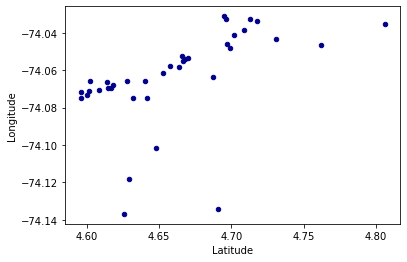

In [121]:
C1=bogota_merged.loc[bogota_merged['Cluster Labels'] == 0]
C1.plot.scatter(x='Latitude',y='Longitude',c='DarkBlue')

#### Cluster 2

In [112]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 1, bogota_merged.columns[[0] + list(range(4, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,LAS CRUCES,Market,Fried Chicken Joint,Burger Joint,Kitchen Supply Store,Yoga Studio,Fast Food Restaurant,Farm,Falafel Restaurant,Fabric Shop,Empanada Restaurant


#### Cluster 3

In [113]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 2, bogota_merged.columns[[0] + list(range(4, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,CEMENTERIO JARDINES APOGEO,Coffee Shop,Arepa Restaurant,Donut Shop,Bus Station,Yoga Studio,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Fabric Shop


#### Cluster 4

In [114]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 3, bogota_merged.columns[[0] + list(range(4, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,BOCHICA II,Mexican Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Burger Joint,Department Store,Men's Store,Breakfast Spot,Shopping Mall,Shoe Store
12,CIUDAD HAYUELOS,Sandwich Place,Fast Food Restaurant,Burger Joint,Pub,Bakery,Ice Cream Shop,Department Store,Pizza Place,Restaurant,Bowling Alley
23,HIPOTECHO OCCIDENTAL,Sandwich Place,Fast Food Restaurant,Donut Shop,Coffee Shop,Department Store,Multiplex,Burger Joint,Restaurant,Paper / Office Supplies Store,Brewery
24,JULIO FLOREZ,Burger Joint,Fast Food Restaurant,ATM,Café,Supermarket,Furniture / Home Store,Taco Place,Bakery,Donut Shop,BBQ Joint
38,LAS VILLAS,Sandwich Place,BBQ Joint,Bakery,Pizza Place,Fast Food Restaurant,Candy Store,Café,Italian Restaurant,Steakhouse,Casino
41,LOS ANDES,Fast Food Restaurant,Burger Joint,Sporting Goods Shop,Juice Bar,Bakery,Food Court,Fried Chicken Joint,Middle Eastern Restaurant,Pizza Place,Restaurant
42,METROPOLIS,Coffee Shop,Donut Shop,Burger Joint,Department Store,Café,Fast Food Restaurant,Steakhouse,Supermarket,Sandwich Place,Fried Chicken Joint
46,PALOQUEMAO,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place,BBQ Joint,Pub,Food Court,Sporting Goods Shop,Asian Restaurant,Chinese Restaurant,Brazilian Restaurant
48,PROVIVIENDA ORIENTAL,Fast Food Restaurant,Sandwich Place,Donut Shop,Multiplex,Coffee Shop,Restaurant,Burger Joint,Department Store,Shopping Mall,Brewery
53,SAN ANTONIO NOROCCIDENTAL,Burger Joint,Coffee Shop,Auto Garage,Mexican Restaurant,Electronics Store,Donut Shop,Fried Chicken Joint,Supermarket,Diner,Cafeteria


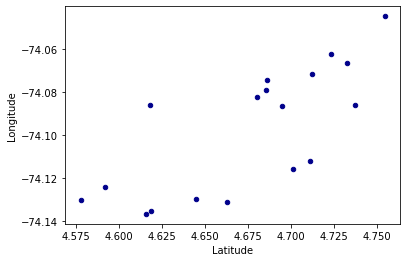

In [124]:
C4=bogota_merged.loc[bogota_merged['Cluster Labels'] == 3]
C4.plot.scatter(x='Latitude',y='Longitude',c='DarkBlue')

#### Cluster 5

In [115]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 4, bogota_merged.columns[[0] + list(range(4, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,ANTIGUO COUNTRY,Hotel,Gym,Bar,Italian Restaurant,Cocktail Bar,South American Restaurant,Supermarket,French Restaurant,Food Truck,Japanese Restaurant
2,BELLAVISTA,Restaurant,Coffee Shop,Bakery,Latin American Restaurant,Hotel,Peruvian Restaurant,Pizza Place,Ice Cream Shop,Café,Bookstore
9,CHICO NORTE,Hotel,Restaurant,Coffee Shop,Burger Joint,Italian Restaurant,Gym / Fitness Center,Bakery,Pub,Salad Place,Asian Restaurant
10,CHICO NORTE II SECTOR,Restaurant,Hotel,Coffee Shop,Bakery,Spanish Restaurant,Gym / Fitness Center,Café,Burger Joint,Latin American Restaurant,Breakfast Spot
11,CHICO NORTE III SECTOR,Hotel,Coffee Shop,Restaurant,Italian Restaurant,Gym / Fitness Center,Pharmacy,Supermarket,Bakery,Breakfast Spot,Seafood Restaurant
15,EL CHICO,Hotel,Italian Restaurant,Pizza Place,Burger Joint,Coffee Shop,Mexican Restaurant,Asian Restaurant,Restaurant,Ice Cream Shop,BBQ Joint
18,EMAUS,Coffee Shop,Hotel,Restaurant,Bakery,Italian Restaurant,Park,Juice Bar,Latin American Restaurant,Breakfast Spot,Burger Joint
21,GRANADA,Coffee Shop,Hotel,Italian Restaurant,Bakery,Restaurant,Park,Pizza Place,Plaza,Juice Bar,Bistro
26,LA CALLEJA,Gym,Shopping Mall,Dessert Shop,Hotel,Market,Restaurant,Italian Restaurant,Spa,Café,Casino
30,LA ESPERANZA NORTE,Coffee Shop,Sushi Restaurant,Juice Bar,Restaurant,Fast Food Restaurant,Italian Restaurant,Burger Joint,Hotel,Sandwich Place,Latin American Restaurant


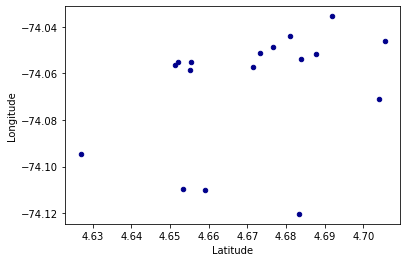

In [123]:
C5=bogota_merged.loc[bogota_merged['Cluster Labels'] == 4]
C5.plot.scatter(x='Latitude',y='Longitude',c='DarkBlue')

## Results 

Our analysis shows that although there is a great number of restaurants in Bogotá, there are pockets of low restaurant density on the east and north. Highest concentration of restaurants was detected on west and downtwon , so we focused our attention to areasto north-west, west and south west, corresponding to boroughs Chapinero, Usaquen and Santa Fe. Another borough was identified as potentially interesting (Salitre), but our attention was focused on Chapinero and Usaquen which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics.





## Conclusion 

After the Clustering  was applied, the cluster number 1 and 4, showed a high density of restaurants of different categories, however as can be seen in the map and the scatter plot, it can be seen that the neighborhoods of cluster 1 are geographically closer, which would allow positioning the supply store that would have a greater potential market, reason why it is necessary to look for a location in one of these neighborhoods.